<a href="https://colab.research.google.com/github/hsingh8015/project3_imageclassification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
import pandas as pd
import requests
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Read the CSV file using the correct path
bird_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FinalProject/warbler_image_labels.csv")

# Set the image path
image_path = "/content/drive/MyDrive/Colab Notebooks/FinalProject/New_Warbler_images"

bird_df.head()

Mounted at /content/drive


,filename,label
0,Image_1.jpg,158.Bay_breasted_Warbler
1,Image_2.jpg,158.Bay_breasted_Warbler
2,Image_3.jpg,158.Bay_breasted_Warbler
3,Image_4.jpg,158.Bay_breasted_Warbler
4,Image_5.jpg,158.Bay_breasted_Warbler


<ipython-input-3-7c4dea3fc1b6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes.index, y=classes.values, palette='plasma')


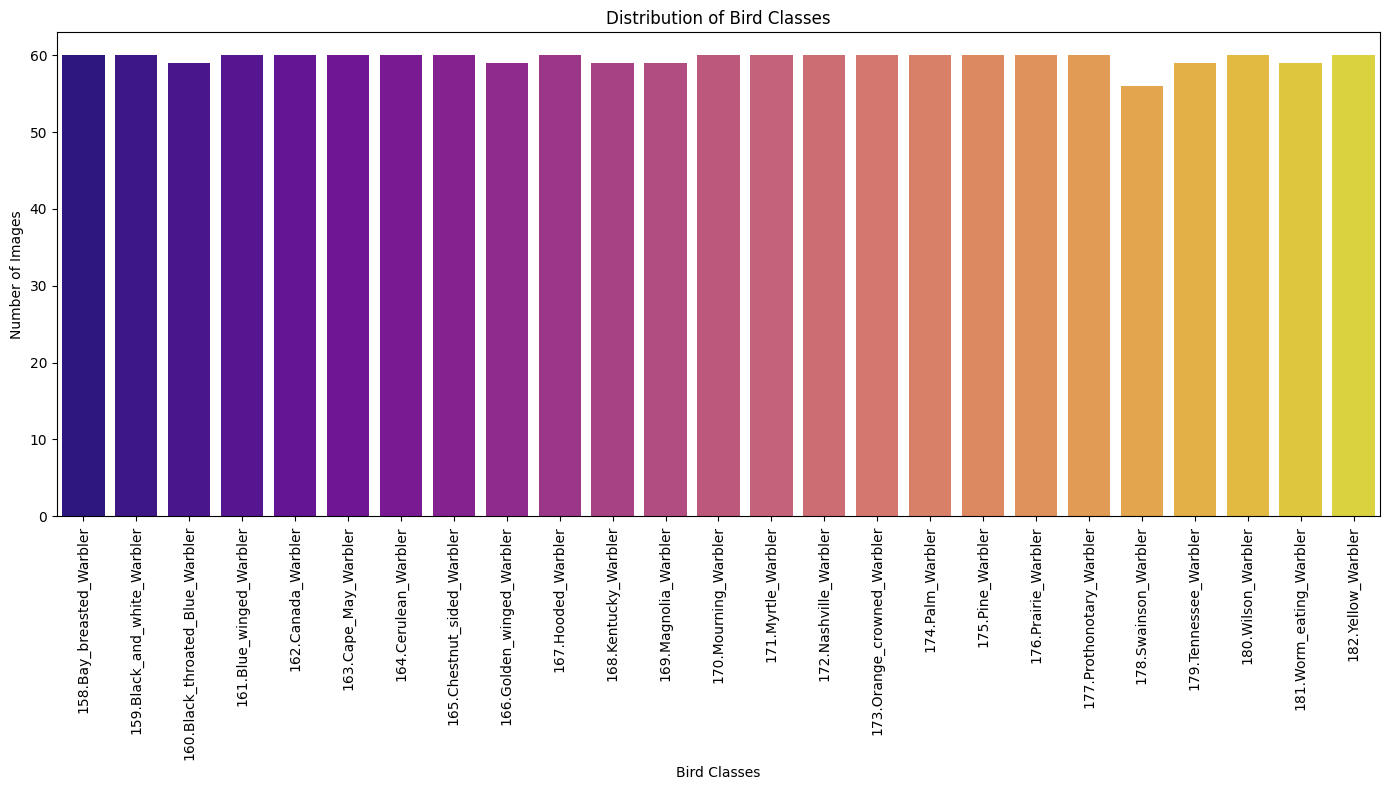

In [3]:
classes = bird_df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=classes.index, y=classes.values, palette='plasma')
plt.title('Distribution of Bird Classes')
plt.xlabel('Bird Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
images = []


for i in range(len(bird_df)):
    filename = bird_df.iloc[i, 0]
    path = os.path.join(image_path, filename)
    print(f'{i + 1} of {len(bird_df)}: Attempting to import {filename}')

    if not os.path.exists(path):
        print(f'FAILED: {filename} does not exist at {path}')
        continue

    try:
        # Use context manager to automatically close the file after opening
        with Image.open(path) as img:
            img = img.convert("RGB")  # Standardize to RGB
            images.append(img.copy())  # Append a copy of the image to close original
    except (IOError, SyntaxError, OSError) as e:
        print(f'FAILED to import {filename} at index {i + 1}, Error: {e}')

1 of 1490: Attempting to import Image_1.jpg
2 of 1490: Attempting to import Image_2.jpg
3 of 1490: Attempting to import Image_3.jpg
4 of 1490: Attempting to import Image_4.jpg
5 of 1490: Attempting to import Image_5.jpg
6 of 1490: Attempting to import Image_6.jpg
7 of 1490: Attempting to import Image_7.jpg
8 of 1490: Attempting to import Image_8.jpg
9 of 1490: Attempting to import Image_9.jpg
10 of 1490: Attempting to import Image_10.jpg
11 of 1490: Attempting to import Image_11.jpg
12 of 1490: Attempting to import Image_12.jpg
13 of 1490: Attempting to import Image_13.jpg
14 of 1490: Attempting to import Image_14.jpg
15 of 1490: Attempting to import Image_15.jpg
16 of 1490: Attempting to import Image_16.jpg
17 of 1490: Attempting to import Image_17.jpg
18 of 1490: Attempting to import Image_18.jpg
19 of 1490: Attempting to import Image_19.jpg
20 of 1490: Attempting to import Image_20.jpg
21 of 1490: Attempting to import Image_21.jpg
22 of 1490: Attempting to import Image_22.jpg
23 of 

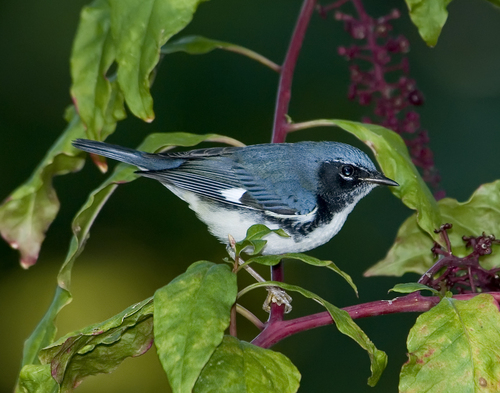

In [5]:
images[123]

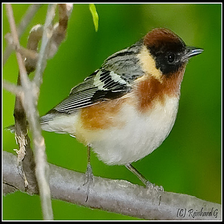

In [6]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes
# Use a for loop to resize all images to 224
target_size = (224, 224)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[4]

In [7]:
float_images = [np.array(img).astype(np.float32) for img in resized_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(float_images[0])

Pixel Values:
[[[172. 164. 159.]
  [170. 169. 163.]
  [173. 186. 175.]
  ...
  [101. 126.  34.]
  [100. 128.  35.]
  [ 99. 128.  35.]]

 [[168. 161. 158.]
  [181. 177. 175.]
  [181. 181. 172.]
  ...
  [100. 125.  33.]
  [101. 126.  34.]
  [102. 128.  36.]]

 [[174. 166. 160.]
  [176. 173. 166.]
  [189. 185. 184.]
  ...
  [101. 126.  34.]
  [101. 127.  34.]
  [101. 129.  35.]]

 ...

 [[ 82. 170.  39.]
  [ 86. 172.  42.]
  [ 87. 171.  42.]
  ...
  [125. 208.  74.]
  [125. 209.  78.]
  [124. 211.  79.]]

 [[ 86. 171.  43.]
  [ 89. 171.  43.]
  [ 92. 174.  46.]
  ...
  [124. 209.  73.]
  [124. 210.  72.]
  [124. 211.  74.]]

 [[ 88. 172.  43.]
  [ 92. 173.  45.]
  [ 92. 173.  44.]
  ...
  [122. 209.  71.]
  [124. 209.  75.]
  [125. 211.  80.]]]


In [8]:
# To normalize images to a range between 0 and 1,
# we need to divide all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(normalized_images[0])

Pixel Values:
[[[0.6745098  0.6431373  0.62352943]
  [0.6666667  0.6627451  0.6392157 ]
  [0.6784314  0.7294118  0.6862745 ]
  ...
  [0.39607844 0.49411765 0.13333334]
  [0.39215687 0.5019608  0.13725491]
  [0.3882353  0.5019608  0.13725491]]

 [[0.65882355 0.6313726  0.61960787]
  [0.70980394 0.69411767 0.6862745 ]
  [0.70980394 0.70980394 0.6745098 ]
  ...
  [0.39215687 0.49019608 0.12941177]
  [0.39607844 0.49411765 0.13333334]
  [0.4        0.5019608  0.14117648]]

 [[0.68235296 0.6509804  0.627451  ]
  [0.6901961  0.6784314  0.6509804 ]
  [0.7411765  0.7254902  0.72156864]
  ...
  [0.39607844 0.49411765 0.13333334]
  [0.39607844 0.49803922 0.13333334]
  [0.39607844 0.5058824  0.13725491]]

 ...

 [[0.32156864 0.6666667  0.15294118]
  [0.3372549  0.6745098  0.16470589]
  [0.34117648 0.67058825 0.16470589]
  ...
  [0.49019608 0.8156863  0.2901961 ]
  [0.49019608 0.81960785 0.30588236]
  [0.4862745  0.827451   0.30980393]]

 [[0.3372549  0.67058825 0.16862746]
  [0.34901962 0.6705882

In [9]:
bird_df['filename'] = bird_df['filename'].str.replace('.jpg', '', regex=False)
bird_df.head()

,filename,label
0,Image_1,158.Bay_breasted_Warbler
1,Image_2,158.Bay_breasted_Warbler
2,Image_3,158.Bay_breasted_Warbler
3,Image_4,158.Bay_breasted_Warbler
4,Image_5,158.Bay_breasted_Warbler


In [10]:
# Now we can call our preprocessed pixel data 'X'
X = normalized_images

# For our purposes, we'll select the label column as 'y'
y = bird_df['label']

In [11]:
# Check the total number of classes
y.nunique()

25

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
# Now we'll split our data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),         # Rotate by 10%
    tf.keras.layers.RandomTranslation(0.15, 0.15), # Shift horizontally and vertically by 15%
    tf.keras.layers.RandomZoom(0.1),             # Zoom in/out by 10%
    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

5585
5585


In [15]:
# Reshape test data for the model
X_test_np = []
for img in X_test:
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape

(224, 224, 3)

In [16]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.2, random_state=42)

# Print the total number of one_hot_encoded columns
np.array(y_train).shape

(4468, 25)

In [17]:
import json
class_order = y_encoder.categories_[0].tolist()
with open('class_order.json', 'w') as f:
    json.dump(class_order, f)

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Start with a smaller learning rate
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitors validation loss
    patience=20,                  # Stops if no improvement in 20 epochs
    restore_best_weights=True    # Restores best weights if stopped early
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Reduce LR if no improvement for 2 epochs
    min_lr=1e-6
)

In [44]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    # First conv block - consider increasing initial filters
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Increased from 32 to 64
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Reduced from 0.3 to prevent too much dropout early

    # Second conv block
    layers.Conv2D(128, (3, 3), activation='relu'),  # Increased from 64 to 128
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),  # Reduced from 0.4

    # Third conv block
    layers.Conv2D(256, (3, 3), activation='relu'),  # Increased from 128 to 256
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fourth conv block
    layers.Conv2D(512, (3, 3), activation='relu'),  # Increased from 256 to 512
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased from 128 to 256
    BatchNormalization(),
    Dropout(0.5),
    layers.Dense(25, activation='softmax')  # Output layer stays the same
])

# Compilation with better learning rate and added decay
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Increased from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training with better parameters
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Keep at 50 epochs
    batch_size=32,
    callbacks=[
        # Early stopping with more patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,  # Increased from 3
            restore_best_weights=True
        ),
        # Learning rate reduction
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 68s 334ms/step - accuracy: 0.0693 - loss: 4.0865 - val_accuracy: 0.0528 - val_loss: 4.6697 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.1602 - loss: 3.1357 - val_accuracy: 0.0367 - val_loss: 4.3716 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.2183 - loss: 2.7208 - val_accuracy: 0.0600 - val_loss: 3.8291 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.2861 - loss: 2.3901 - val_accuracy: 0.1835 - val_loss: 2.8147 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.3309 - loss: 2.1926 - val_accuracy: 0.2784 - val_loss: 2.4045 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.4518 - loss: 1.8474 - val_accuracy: 0.2954 - val_loss: 2.3919 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.5

In [37]:
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.optimizers import Adam

# model = keras.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     Dropout(0.3),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     Dropout(0.4),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     Dropout(0.4),

#     # New additional layer block
#     layers.Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     Dropout(0.4),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     layers.Dense(25, activation='softmax')
# ])

# # Define early stopping with patience of 3 epochs
# model.compile(optimizer=Adam(learning_rate=0.001),  # Set a fixed initial learning rate
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train with both early stopping and reduce_lr
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,  # Increased to 50 epochs
#     batch_size=32,
#     callbacks=[early_stopping, reduce_lr]  # Now you can use `reduce_lr`
# )

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.0758 - loss: 3.8001 - val_accuracy: 0.0403 - val_loss: 6.3197 - learning_rate: 0.0010
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1268 - loss: 3.1611 - val_accuracy: 0.0331 - val_loss: 5.2496 - learning_rate: 0.0010
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1588 - loss: 2.9839 - val_accuracy: 0.0600 - val_loss: 3.3455 - learning_rate: 0.0010
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2025 - loss: 2.6892 - val_accuracy: 0.1289 - val_loss: 3.0959 - learning_rate: 0.0010
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2637 - loss: 2.4736 - val_accuracy: 0.1719 - val_loss: 2.8629 - learning_rate: 0.0010
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.3051 - loss: 2.3020 - val_accuracy: 0.1782 - val_loss: 2.7849 - learning_rate: 0.0010
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.3838 - loss: 

In [45]:
#evaluate the model
model.evaluate(X_test_np, y_test_np)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.2523 - loss: 3.3370


[3.328429937362671, 0.262734591960907]

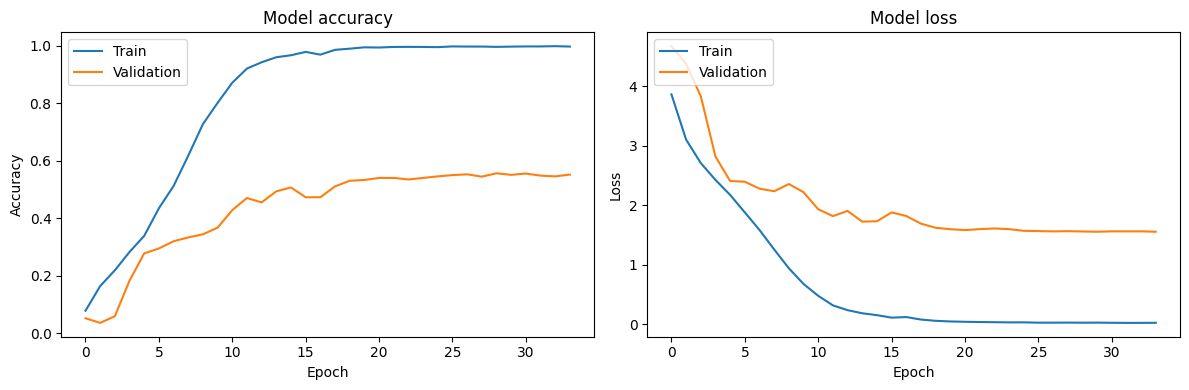

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# model = model.save('warbler_model.keras')


In [47]:
y_pred_probs = model.predict(X_val)
# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1) # Predicted class labels
y_true = np.argmax(y_val, axis=1) # True class labels
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Confusion Matrix:
[[26  0  1  0  0  0  0  2  1  0  0  0  0  0  1  0  4  0  0  0  0  2  0  0
   0]
 [ 0 24  2  0  2  0  0  1  0  0  0  0  0  4  0  0  2  0  0  0  1  0  0  0
   0]
 [ 2  0 28  0  0  1  2  2  0  0  0  0  0  2  0  1  0  0  0  0  0  2  0  0
   0]
 [ 1  0  0 17  3  1  0  0  0  1  0  0  2  1  1  0  1  1  0  0  0  0  2  0
   3]
 [ 2  2  0  0 27  1  0  0  0  2  2  2  2  2  0  2  0  0  3  0  0  0  6  0
   2]
 [ 3  0  0  0  1 22  0  1  1  1  0  0  1  3  0  0  4  1  2  0  1  2  0  0
   2]
 [ 0  2  1  0  0  0 30  0  0  0  1  0  0  2  0  0  0  0  0  0  1  0  0  0
   0]
 [ 2  3  1  0  1  1  1 29  3  0  1  0  1  3  2  2  4  0  0  0  0  0  0  1
   0]
 [ 0  0  3  1  1  0  2  0 19  2  0  2  0  1  3  0  0  0  0  0  0  1  0  0
   0]
 [ 0  0  0  1  0  4  0  0  1 33  2  0  0  0  2  1  0  0  1  2  0  0  6  1
   1]
 [ 0  0  1  0  2  0  0  0  0  3 18  0  3  2  4  0  0  1  0  0  1  0  1  1
   1]
 [ 1  2  0  0  3  2  0  1  0  2  0 36  0  0  0  1  0  2  0  1 

In [58]:
classes

,count
label,
158.Bay_breasted_Warbler,60
159.Black_and_white_Warbler,60
160.Black_throated_Blue_Warbler,59
161.Blue_winged_Warbler,60
162.Canada_Warbler,60
163.Cape_May_Warbler,60
164.Cerulean_Warbler,60
165.Chestnut_sided_Warbler,60
166.Golden_winged_Warbler,59


In [62]:
cm_df=pd.DataFrame(conf_matrix, columns=classes.index, index=classes.index)

cm_df


label,158.Bay_breasted_Warbler,159.Black_and_white_Warbler,160.Black_throated_Blue_Warbler,161.Blue_winged_Warbler,162.Canada_Warbler,163.Cape_May_Warbler,164.Cerulean_Warbler,165.Chestnut_sided_Warbler,166.Golden_winged_Warbler,167.Hooded_Warbler,...,173.Orange_crowned_Warbler,174.Palm_Warbler,175.Pine_Warbler,176.Prairie_Warbler,177.Prothonotary_Warbler,178.Swainson_Warbler,179.Tennessee_Warbler,180.Wilson_Warbler,181.Worm_eating_Warbler,182.Yellow_Warbler
label,,,,,,,,,,,,,,,,,,,,,
158.Bay_breasted_Warbler,26,0,1,0,0,0,0,2,1,0,...,0,4,0,0,0,0,2,0,0,0
159.Black_and_white_Warbler,0,24,2,0,2,0,0,1,0,0,...,0,2,0,0,0,1,0,0,0,0
160.Black_throated_Blue_Warbler,2,0,28,0,0,1,2,2,0,0,...,1,0,0,0,0,0,2,0,0,0
161.Blue_winged_Warbler,1,0,0,17,3,1,0,0,0,1,...,0,1,1,0,0,0,0,2,0,3
162.Canada_Warbler,2,2,0,0,27,1,0,0,0,2,...,2,0,0,3,0,0,0,6,0,2
163.Cape_May_Warbler,3,0,0,0,1,22,0,1,1,1,...,0,4,1,2,0,1,2,0,0,2
164.Cerulean_Warbler,0,2,1,0,0,0,30,0,0,0,...,0,0,0,0,0,1,0,0,0,0
165.Chestnut_sided_Warbler,2,3,1,0,1,1,1,29,3,0,...,2,4,0,0,0,0,0,0,1,0
166.Golden_winged_Warbler,0,0,3,1,1,0,2,0,19,2,...,0,0,0,0,0,0,1,0,0,0


In [48]:
ccimport numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get the predictions and true labels as before
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Add analysis code
print("Model Prediction Analysis:")
print("-" * 50)
print(f"Number of total predictions: {len(y_pred)}")
print(f"Unique classes predicted: {np.unique(y_pred)}")
print(f"Distribution of predictions:")
for class_idx, count in enumerate(np.bincount(y_pred)):
    print(f"Class {class_idx}: {count} predictions")

print("\nPrediction Statistics:")
print("-" * 50)
# Calculate what percentage of predictions are the most common class
dominant_class = np.argmax(np.bincount(y_pred))
dominant_class_percentage = (y_pred == dominant_class).mean() * 100
print(f"Dominant class: {dominant_class}")
print(f"Percentage of predictions in dominant class: {dominant_class_percentage:.2f}%")

# Print detailed classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_true, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Model Prediction Analysis:
--------------------------------------------------
Number of total predictions: 1117
Unique classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Distribution of predictions:
Class 0: 50 predictions
Class 1: 38 predictions
Class 2: 44 predictions
Class 3: 27 predictions
Class 4: 47 predictions
Class 5: 44 predictions
Class 6: 41 predictions
Class 7: 46 predictions
Class 8: 30 predictions
Class 9: 58 predictions
Class 10: 41 predictions
Class 11: 43 predictions
Class 12: 38 predictions
Class 13: 52 predictions
Class 14: 49 predictions
Class 15: 49 predictions
Class 16: 62 predictions
Class 17: 34 predictions
Class 18: 41 predictions
Class 19: 35 predictions
Class 20: 55 predictions
Class 21: 37 predictions
Class 22: 51 predictions
Class 23: 45 predictions
Class 24: 60 predictions

Prediction Statistics:
--------------------------------------------------
Dominant class: 16
Percen

In [42]:
# Print value counts of true labels to see actual distribution
print("True label distribution:")
print(np.bincount(y_true))

# If you have label names/mappings, we can print those:
# Assuming you have a label_names list or dictionary
# print("Class 12 represents:", label_names[12])

True label distribution:
[37 36 40 34 55 45 37 55 35 55 38 53 45 51 47 41 46 45 41 42 49 46 51 39
 54]


In [43]:
# Check class balance in training data
print("\nTraining data distribution:")
train_distribution = np.bincount(np.argmax(y_train, axis=1))
for i, count in enumerate(train_distribution):
    print(f"Class {i}: {count} samples ({count/len(y_train)*100:.2f}%)")

# Check model's predict_proba output to see confidence levels
probabilities = model.predict_proba(X_val)
print("\nAverage probability for each class:")
print(np.mean(probabilities, axis=0))


Training data distribution:
Class 0: 193 samples (4.32%)
Class 1: 174 samples (3.89%)
Class 2: 200 samples (4.48%)
Class 3: 191 samples (4.27%)
Class 4: 160 samples (3.58%)
Class 5: 195 samples (4.36%)
Class 6: 188 samples (4.21%)
Class 7: 180 samples (4.03%)
Class 8: 165 samples (3.69%)
Class 9: 205 samples (4.59%)
Class 10: 177 samples (3.96%)
Class 11: 172 samples (3.85%)
Class 12: 170 samples (3.80%)
Class 13: 164 samples (3.67%)
Class 14: 173 samples (3.87%)
Class 15: 194 samples (4.34%)
Class 16: 189 samples (4.23%)
Class 17: 160 samples (3.58%)
Class 18: 164 samples (3.67%)
Class 19: 188 samples (4.21%)
Class 20: 171 samples (3.83%)
Class 21: 149 samples (3.33%)
Class 22: 179 samples (4.01%)
Class 23: 166 samples (3.72%)
Class 24: 201 samples (4.50%)


AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [ ]:
# files.download('warbler_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# files.download('class_order.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>